# HuggingFace Model

In [53]:
from transformers import pipeline

In [54]:
image_caption = pipeline('image-to-text', model="ydshieh/vit-gpt2-coco-en")

2023-05-08 14:42:15.601718: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFVisionEncoderDecoderModel.

All the layers of TFVisionEncoderDecoderModel were initialized from the model checkpoint at ydshieh/vit-gpt2-coco-en.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFVisionEncoderDecoderModel for predictions without further training.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  war

In [100]:
with open('/Users/kevinkang/Desktop/brown_cs/cs1430-cv/final/1430CV-image-captioning/data/flickr8k/captions.txt', 'r') as f:
    content = f.read().splitlines()[1:]

image_names = []
for i in range(0,len(content),5):
    image_names.append(content[i].split(',')[0])

In [31]:
generated_captions = []

for image_name in image_names[:10]:
    generated_captions.append(image_caption(f'../data/flickr8k/images/{image_name}')[0]['generated_text'])

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/generation/tf_utils.py:854: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


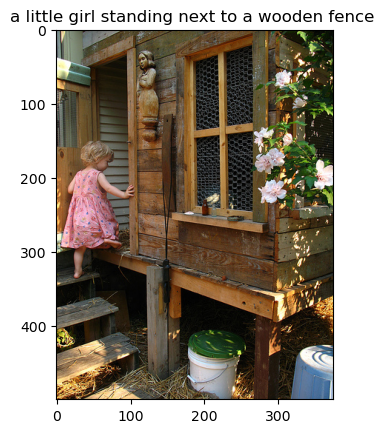

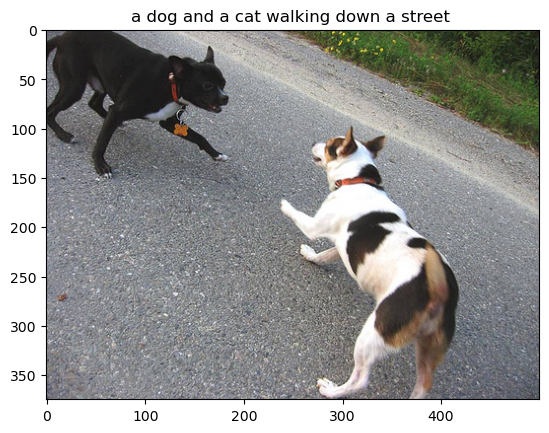

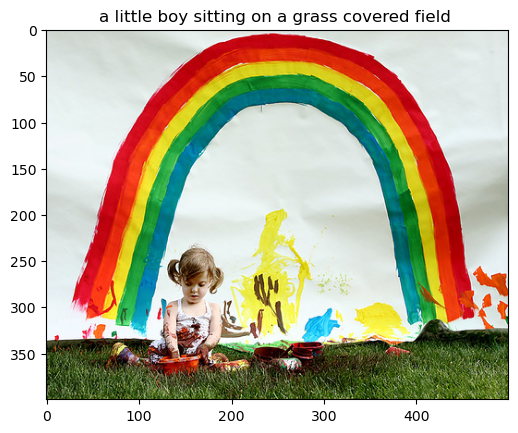

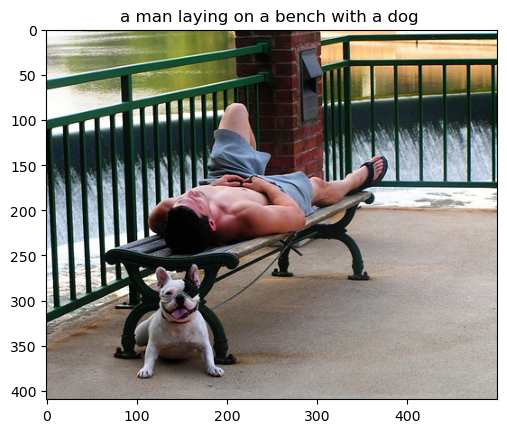

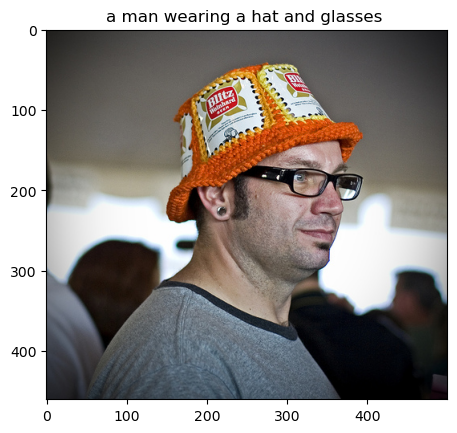

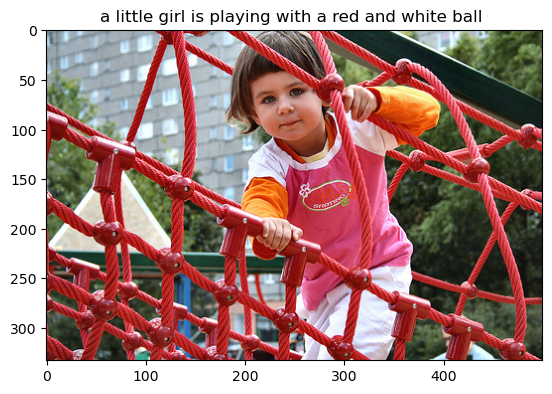

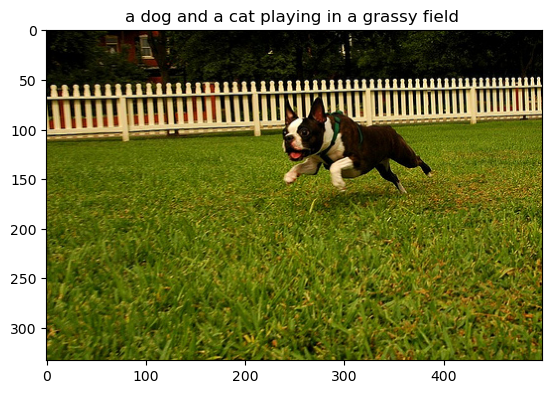

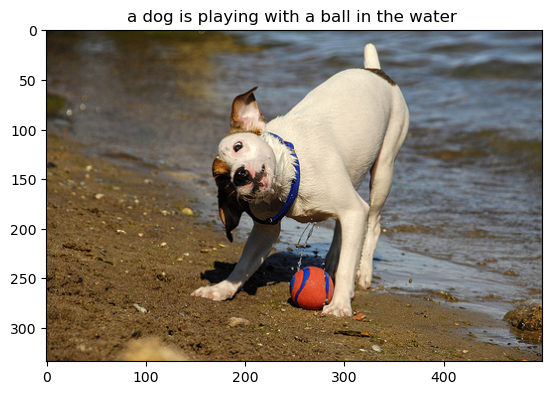

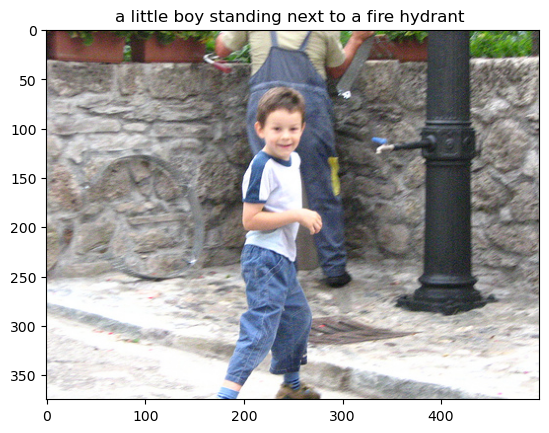

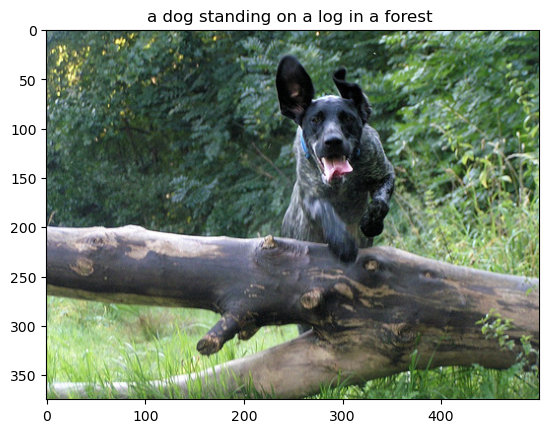

In [32]:
#visualize the images and their captions
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(10):
    image_name = image_names[i]
    image_path = f'../data/flickr8k/images/{image_name}'
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.title(f"{generated_captions[i]}")
    plt.show()


In [112]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import random 

#dictionary of index to image name
index_to_image_name = {}
for i, image_name in enumerate(image_names):
    index_to_image_name[i] = image_name

#dictionary of image name to index
image_name_to_index = {}
for i, image_name in enumerate(image_names):
    image_name_to_index[image_name] = i

#dictionary of index to caption
index_to_caption = {}
for i in range(0,len(content),5):
    index_to_caption[int(i/5)] = content[i].split(',')[1]

def get_BLEU_score(split=None):
    """
    Helper function to calculate the BLEU score of the model on a random subset of the test set.

    :param num_images: the number of images to randomly select from the test set
    :return: the BLEU score
    """

    # train test split
    if split is None:
        split = int(len(image_names)*0.1)

    #shuffle but dont change the original list
    copy_image_names = image_names.copy()
    random.shuffle(copy_image_names)
    test_images = copy_image_names[:split]

    # get the predicted captions for the selected images
    predicted_captions = []
    for name in tqdm(test_images, desc="Generating captions"):
        predicted_captions.append(image_caption(f'../data/flickr8k/images/{name}')[0]['generated_text'])

    # get the actual captions for the selected images
    actual_captions = []
    for name in tqdm(test_images, desc="Getting actual captions"):
        actual_captions.append([index_to_caption[image_name_to_index[name]].lower()])

    # calculate the BLEU score
    return corpus_bleu(actual_captions, predicted_captions), actual_captions, predicted_captions
    

score, actual_captions, predicted_captions = get_BLEU_score(300)

Getting actual captions: 100%|██████████| 300/300 [00:00<00:00, 24137.10it/s]


In [134]:
print("BLEU score for flickr8k:", score)

BLEU score for flickr8k: 0.31012165998486896


# Fine-tuned Model

### Preprocessing

In [1]:
#imports
from transformers import TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

In [90]:
ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

Found cached dataset parquet (/Users/kevinkang/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

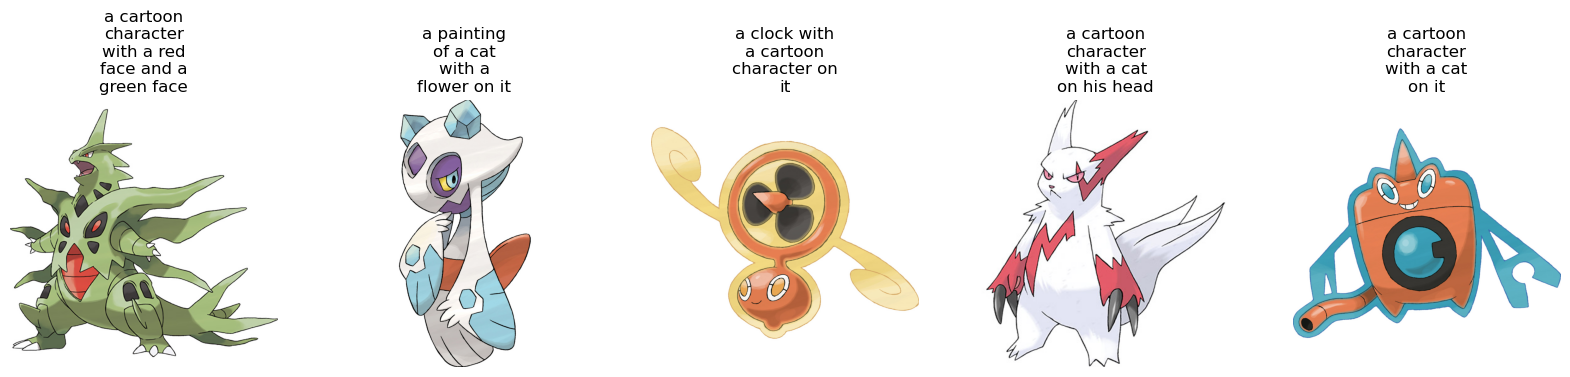

In [64]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [train_ds[i]["image"] for i in range(5)]
sample_captions = [image_caption(sample_images_to_visualize[i])[0]['generated_text'] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [92]:
from transformers import ViTFeatureExtractor

checkpoint = "nlpconnect/vit-gpt2-image-captioning"
processor = ViTFeatureExtractor.from_pretrained(checkpoint)

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [93]:
import numpy as np

def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length", return_tensors="tf")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)



#convert train_ds and test_ds to tf.data.Dataset, using prepare_tf_dataset
train_ds = train_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask", "images", "labels"],
    shuffle=True,
    batch_size=8,
)
test_ds = test_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask", "images", "labels"],
    shuffle=False,
    batch_size=8,
)


TypeError: to_tf_dataset() missing 1 required positional argument: 'batch_size'

In [88]:
from transformers import GPT2Config

checkpoint = "nlpconnect/vit-gpt2-image-captioning"
model = GPT2Config.from_pretrained(checkpoint)


You are using a model of type vision-encoder-decoder to instantiate a model of type gpt2. This is not supported for all configurations of models and can yield errors.


In [74]:
from transformers import TFTrainingArguments, TFTrainer

model_name = checkpoint.split("/")[1]

training_args = TFTrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [75]:
from evaluate import load
import torch

wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [76]:
import tensorflow as tf

trainer = TFTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/trainer_tf.py:118: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(
2023-05-08 15:06:04.445169: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 599
  }
}
attr {
  key: "is_files"
  value {
    b: fa

ValueError: `Checkpoint` was expecting a trackable object (an object derived from `TrackableBase`), got GPT2Config {
  "_name_or_path": "vit-gpt-pt",
  "activation_function": "gelu_new",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder": {
    "_name_or_path": "",
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "bad_words_ids": null,
    "bos_token_id": 50256,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": 50256,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "embd_pdrop": 0.1,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 50256,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0": 0,
      "LABEL_1": 1
    },
    "layer_norm_epsilon": 1e-05,
    "length_penalty": 1.0,
    "max_length": 20,
    "min_length": 0,
    "model_type": "gpt2",
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 12,
    "n_positions": 1024,
    "no_repeat_ngram_size": 0,
    "num_beam_groups": 1,
    "num_beams": 1,
    "num_return_sequences": 1,
    "output_attentions": false,
    "output_hidden_states": false,
    "output_scores": false,
    "pad_token_id": 50256,
    "prefix": null,
    "problem_type": null,
    "pruned_heads": {},
    "remove_invalid_values": false,
    "reorder_and_upcast_attn": false,
    "repetition_penalty": 1.0,
    "resid_pdrop": 0.1,
    "return_dict": true,
    "return_dict_in_generate": false,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "sep_token_id": null,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "summary_proj_to_labels": true,
    "summary_type": "cls_index",
    "summary_use_proj": true,
    "task_specific_params": {
      "text-generation": {
        "do_sample": true,
        "max_length": 50
      }
    },
    "temperature": 1.0,
    "tie_encoder_decoder": false,
    "tie_word_embeddings": true,
    "tokenizer_class": null,
    "top_k": 50,
    "top_p": 1.0,
    "torch_dtype": null,
    "torchscript": false,
    "transformers_version": "4.15.0",
    "use_bfloat16": false,
    "use_cache": true,
    "vocab_size": 50257
  },
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "encoder": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": [
      "ViTModel"
    ],
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.0,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "image_size": 224,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
    "is_decoder": false,
    "is_encoder_decoder": false,
    "label2id": {
      "LABEL_0": 0,
      "LABEL_1": 1
    },
    "layer_norm_eps": 1e-12,
    "length_penalty": 1.0,
    "max_length": 20,
    "min_length": 0,
    "model_type": "vit",
    "no_repeat_ngram_size": 0,
    "num_attention_heads": 12,
    "num_beam_groups": 1,
    "num_beams": 1,
    "num_channels": 3,
    "num_hidden_layers": 12,
    "num_return_sequences": 1,
    "output_attentions": false,
    "output_hidden_states": false,
    "output_scores": false,
    "pad_token_id": null,
    "patch_size": 16,
    "prefix": null,
    "problem_type": null,
    "pruned_heads": {},
    "qkv_bias": true,
    "remove_invalid_values": false,
    "repetition_penalty": 1.0,
    "return_dict": true,
    "return_dict_in_generate": false,
    "sep_token_id": null,
    "task_specific_params": null,
    "temperature": 1.0,
    "tie_encoder_decoder": false,
    "tie_word_embeddings": true,
    "tokenizer_class": null,
    "top_k": 50,
    "top_p": 1.0,
    "torch_dtype": null,
    "torchscript": false,
    "transformers_version": "4.15.0",
    "use_bfloat16": false
  },
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50257
}
. If you believe this object should be trackable (i.e. it is part of the TensorFlow Python API and manages state), please open an issue.

ValueError: You need to specify either `text` or `text_target`.

ImportError: cannot import name 'ViTForImageCaptioning' from 'transformers' (/Users/kevinkang/opt/miniconda3/envs/dl3/lib/python3.9/site-packages/transformers/__init__.py)